## This script is that same as the pre_process_V1.py for SEEG2. 
### 100 setences.


In [2]:
import calendar
import datetime
import glob
from utils.util_MNE import delete_annotation, keep_annotation
from dSPEECH.config import *
#plott=False

In [3]:
sf=1024
type='SEEG' #'SEEG/ECoG
sid=2 # SEEG 1/2
eeg_file=data_dir+'raw/'+type+str(sid)+'_*/EEG.edf' # SEEG1_datetime
eeg_file=os.path.normpath(glob.glob(eeg_file)[0])
raw = mne.io.read_raw_edf(eeg_file,preload=True)

In [3]:
raw.plot()

![](img/img7.png)

In [4]:
# get the channel names from the recon.ppt file
channel_names=['TP','Am','HA','HP','BT1','BT2','OF','FO','ST1','PO','ST2','ST3','SM','LHA']
# set the channel types
#raw.info.get_channel_types() # All chs are type of 'eeg'
ch_types={}
for chi in raw.ch_names:
    if any([tmp in chi for tmp in channel_names]):
        ch_types[chi]='eeg'
    else:
        ch_types[chi] = 'misc'
raw.set_channel_types(ch_types)
raw.pick(['eeg'])

<RawEDF | EEG.edf, 150 x 3270016 (3193.4 s), ~3.65 GB, data loaded>

In [5]:
len(raw.ch_names)

150

In [ ]:
raw.plot_psd(tmin=0, tmax=600,average=False) # the one that is above the others is ST3-5 (not the spikes)

![](img8.png)

In [6]:
raw.info["bads"].append("ST3-5") #raw.info["bads"].remove("PR")
raw.pick(picks='all',exclude='bads')

<RawEDF | EEG.edf, 149 x 3270016 (3193.4 s), ~3.63 GB, data loaded>

In [7]:
len(raw.ch_names)

149

In [8]:
# line noise
freqs = (50,100,150,200,250,300,350,400,450)
raw.notch_filter(freqs=freqs)
# possible low frequency drift
cutoff=0.1
raw.filter(l_freq=cutoff, h_freq=None)

<RawEDF | EEG.edf, 149 x 3270016 (3193.4 s), ~3.63 GB, data loaded>

### Now look at the PSD profile to further check the bad channels.

/Users/xiaowu/opt/miniconda3/envs/bci/lib/python3.10/site-packages/mne/viz/utils.py:137: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


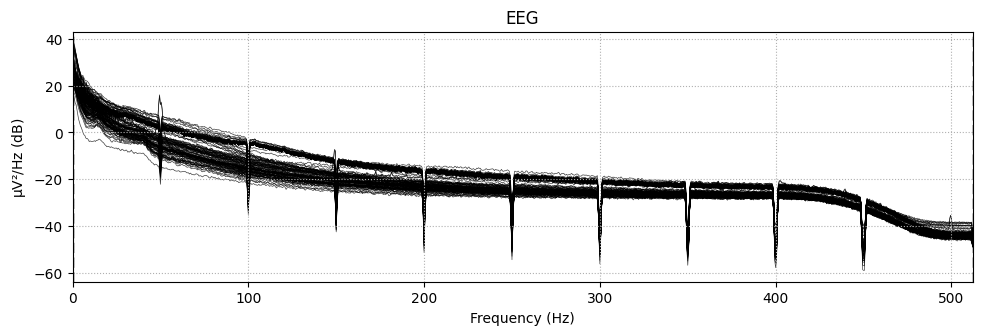

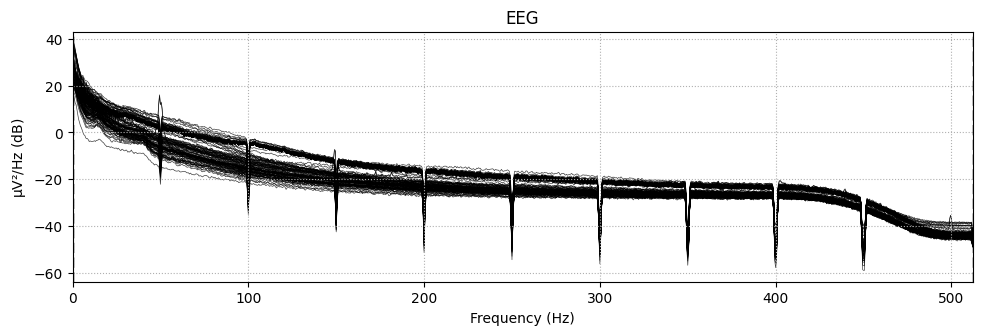

In [9]:
raw.plot_psd(tmin=0, tmax=600, average=False, exclude="bads") # Two more noisy channels, Am-6, Am-7, show strong artifacts around 50 and 150 Hz.

![](img/img9.png)

In [10]:
#raw.drop_channels(['Am-6','Am-7']) 
raw.info["bads"].append("Am-6") #raw.info["bads"].remove("PR")
raw.info["bads"].append("Am-7")
raw.pick(picks='all',exclude='bads')

<RawEDF | EEG.edf, 147 x 3270016 (3193.4 s), ~3.58 GB, data loaded>

### working with triggers

In [7]:
plot_scale=100e-5
plot_channels=5
#raw.plot(duration=100,time_format='clock',n_channels=plot_channels, scalings=dict(eeg=50e-5))


In [11]:
##  extract annotations='TRIG[001]:1'
anno_natus=raw.annotations # annotations come from existing trigger info
if type=='ECoG':
    event_descripion='Patient Event'
else:
    event_descripion = 'TRIG[001]:1'

In [12]:
anno_natus[1]

OrderedDict([('onset', 20.941406),
             ('duration', 0.0),
             ('description', 'TRIG[001]:1'),
             ('orig_time',
              datetime.datetime(2023, 12, 1, 14, 12, 11, tzinfo=datetime.timezone.utc))])

### some annotation is not task-related, such as those marked by the nurse.

![](img/img2.png)

In [13]:
# keep only these trigger with description of 'TRIG[001]:1'.
anno_natus=keep_annotation(anno_natus,event_descripion)
raw.set_annotations(anno_natus)

<RawEDF | EEG.edf, 147 x 3270016 (3193.4 s), ~3.58 GB, data loaded>

In [11]:
# plot it for visual checking: now triggers with other colors are removed
raw.plot(duration=100,n_channels=plot_channels,scalings=dict(eeg=50e-5))

![](img/img11.png)

### Read trigger info from matlab
1, export prompts to inf.txt from matlab using export_logfile_to_text.m file;

2, (Fixed in version 2) Manually add time stamp to 'Resumeing' event. The time of resuming is the same as that of next sentence;

2.5, Save the file;

3, Read inf.txt, and format it to lines in the form of "time, sentence";

In [14]:
filename=data_dir+'raw/'+type+str(sid)+'_*/matlab/inf.txt'
filename=os.path.normpath(glob.glob(filename)[0])
#filename=r'D:\data\speech_Southmead\raw\SEEG1\matlab\inf.txt'
with open(filename,"r") as infile:
    lines_tmp=infile.read().split('\n')
prompts_tmp=[tmpi for tmpi in lines_tmp if len(tmpi)>0]

In [15]:
prompts_tmp

['01-Dec-2023 14:18:57',
 'A cheap tattoo can be obscene.',
 '01-Dec-2023 14:19:12',
 'The sea is teal, not blue or green.',
 '01-Dec-2023 14:19:27',
 'The waxing moon will beam in June.',
 '01-Dec-2023 14:19:42',
 'At noon when we will do Tai Chi.',
 '01-Dec-2023 14:19:57',
 'A group of geese attacked the brat.',
 '01-Dec-2023 14:20:12',
 'The actor sued the camera crew.',
 '01-Dec-2023 14:20:27',
 'The hooves on moose are flat and black.',
 '01-Dec-2023 14:20:43',
 'A tea is brewed with leaves or bags.',
 '01-Dec-2023 14:20:58',
 'A lack of shoes to pad my feet.',
 '01-Dec-2023 14:21:13',
 'I plan my meetings back-to-back.',
 '01-Dec-2023 14:21:28',
 'The steel tycoons will flash their cash.',
 '01-Dec-2023 14:21:43',
 'We scan the beach for scraps of trash.',
 '01-Dec-2023 14:21:58',
 'The bluebird preens its beak and back.',
 '01-Dec-2023 14:22:13',
 'A sleuth will handle tampered clues.',
 '01-Dec-2023 14:22:28',
 'To clean your teeth; remove the plaque.',
 '01-Dec-2023 14:22:43',

In [16]:
# format to lines of the form "time, sentence";
prompts=[] # 106
for i in range(int(len(prompts_tmp)/2)):
    tmp=[]
    tmp.append(prompts_tmp[i*2])
    tmp.append(prompts_tmp[i*2+1])
    prompts.append(tmp)

In [17]:
## create matlab annotation from the prompts : append(onset, duration, description, ch_names=None)
import datetime
calendar_dict={month: index for index, month in enumerate(calendar.month_abbr) if month}
orig_time=anno_natus[0]['orig_time']#datetime.datetime(2023, 11, 17, 9, 51, 34, tzinfo=datetime.timezone.utc)
onsets=[]
durations=[]
descriptions=[]
for prompt in prompts:
    time=prompt[0]
    year=int(time.split(' ')[0].split('-')[-1])
    month_tmp = time.split(' ')[0].split('-')[1]
    month=calendar_dict[month_tmp]
    day = int(time.split(' ')[0].split('-')[0])
    hour = int(time.split(' ')[1].split(':')[0])
    min = int(time.split(' ')[1].split(':')[1])
    sec = int(time.split(' ')[1].split(':')[2])
    ts=datetime.datetime(year, month, day, hour, min, sec, tzinfo=datetime.timezone.utc)

    onset=(ts-orig_time).total_seconds()
    onsets.append(onset)
    durations.append(0)
    if prompt[1]=='Pausing':
        descriptions.append('pause')
    elif prompt[1]=='Resuming':
        descriptions.append('resume')
    elif prompt[1]=='Escape':
        descriptions.append('escape')
    else:
        descriptions.append('TRIG-matlab')
anno_matlab=mne.Annotations(onset=onsets,duration=durations,description=descriptions,orig_time=orig_time)# 106=102triggers+4pauses

In [18]:
## combine annotation from natus and matlab
ann_comb=anno_natus.__add__(anno_matlab)
raw1=raw.copy()
raw1.set_annotations(ann_comb)

<RawEDF | EEG.edf, 147 x 3270016 (3193.4 s), ~3.58 GB, data loaded>

In [55]:
# check annotations of both natus and matlab
raw1.plot(duration=100,n_channels=plot_channels,scalings=dict(eeg=50e-5))

## visually compare triggers from Natus and matlab;

### Add two annotations (program_start, program_end in annotation mode).

Method 1: using GUI:

1,Press 'a' enter annotation mode; 

2, type program_start, then hit enter; 

3, click and drag will create program_start point;

4, type program_end, then hit enter; 

5, click and drag will create program_end point;)

The raw1.annotation will reflect the modified annotation in real-time
(no need to close the figure);

In [53]:
raw1.plot(duration=100,n_channels=plot_channels,scalings=dict(eeg=50e-5)) # put the program_start before the first TRIG[001]:1 (waiting for pressing space bar to start the paradigm), as indicated by the green line below.

![](img4.png)

### Or, add these two annotations by constructing the annotations objects using time and duration, like below:

In [19]:
onsets = [356, 3160]  # s
durations = [5, 5]  # s
descriptions = ['program_start', 'program_end']
anno_start_end = mne.Annotations(onset=onsets, duration=durations, description=descriptions, orig_time=orig_time)
ann_comb = ann_comb.__add__(anno_start_end)
raw1.set_annotations(ann_comb)

<RawEDF | EEG.edf, 147 x 3270016 (3193.4 s), ~3.58 GB, data loaded>

In [20]:
## extract the experimental data by only keeping program_start and program_end triggers;
seg_anno=raw1.annotations.copy()
seg_anno=keep_annotation(seg_anno, ['program_start','program_end'])
# get start time from 'program_start' trigger
tmin=seg_anno[0]['onset']-5 # extra 5 seconds
tmax=seg_anno[1]['onset']+seg_anno[1]['duration']+5 # extra 5 seconds


In [21]:
tmax

3170.0

In [22]:
raw1.crop(tmin=tmin,tmax=tmax)

<RawEDF | EEG.edf, 147 x 2886657 (2819.0 s), ~3.16 GB, data loaded>

In [23]:
## SEEG1,SEEG2: replace the first 'TRIG[001]:1' with 'keyboard_wait'
# trigger sequence: 'program_start', 'TRIG[001]:1 (should be keyboard_wait)',.....,'program_end';
anno_tmp=raw1.annotations.copy()
replace_anno=mne.Annotations(onset=anno_tmp[1]['onset'],duration=anno_tmp[1]['duration'],description='keyboard_wait',orig_time=anno_tmp[1]['orig_time'])
anno_tmp.delete(1) # the second trigger of ('program_start', 'TRIG[001]:1',.....,'program_end')
ann_comb2=anno_tmp+replace_anno
raw1.set_annotations(ann_comb2)

<RawEDF | EEG.edf, 147 x 2886657 (2819.0 s), ~3.16 GB, data loaded>

In [25]:
# check again
raw1.plot(duration=100,time_format='float',n_channels=10,scalings=dict(eeg=50e-5))

###  deal with the missing natus triggers, for example:

![](img/img5.png)

In [26]:
n_natus=[tmp for tmp in raw1.annotations if tmp['description']=='TRIG[001]:1' ]
n_matlab=[tmp for tmp in raw1.annotations if tmp['description']=='TRIG-matlab' ]
diff=len(n_matlab)-len(n_natus) # 4 triggers missing in n_natus

In [34]:
# First, estimate the time difference between triggers
raw1.annotations[4]['onset']-raw1.annotations[2]['onset'] # 15.11/15.099/15.08/15.11/15.08/15.08/15.08/15.08/15.10/

15.118163999999979

In [29]:
trigger_diff=15.09

### indicate the time range of missing triggers

In [30]:
missings=[[740,756],[860,877],[1598,1614],[2691,2708]] # SEEG2
insert = []
for m in missings:
    for n in n_natus:
        if m[0] + tmin < n['onset'] + 15 < m[1] + tmin:
            insert.append(n['onset'] + trigger_diff)  # s

In [31]:
onsets=[]
durations=[]
descriptions=[]
for i in insert:
    onsets.append(i)
    durations.append(0)
    descriptions.append('TRIG[001]:1:inserted')
anno_missing=mne.Annotations(onset=onsets,duration=durations,description=descriptions,orig_time=orig_time)# 106=102triggers+4pauses
ann_comb2_added=ann_comb2.__add__(anno_missing)
raw1.set_annotations(ann_comb2_added)

<RawEDF | EEG.edf, 147 x 2886657 (2819.0 s), ~3.16 GB, data loaded>

In [32]:
len(ann_comb2_added)

215

missing triggers were added, as in below two green lines: (blue ones: matlab triggers; orange ones: natus triggers; green： missing ones)

![](img/img6.png)

### In GUI, delete trials (incomplete trials) right before 'pause' in annotation mode: press 'a' and enter the annotation mode, check the TRIG-matlab annotation and select (click and drag a period) the annotation line, then right-click; do the same for 'TRIG[001]:1'/'TRIG[001]:1:inserted'

4 annotations were deleted.

In [34]:
raw1.plot(duration=100,time_format='float',n_channels=10,scalings=dict(eeg=50e-5)) # delete these annotations (3*2=6) in GUI

In [35]:
ann_comb2_added=raw1.annotations

In [36]:
len(ann_comb2_added)

209

In [37]:
## delete 'program_start'+'keyboard_wait'+'pause'(3)+'resume'(3)+'program_end'
ann_comb2_added=delete_annotation(ann_comb2_added,['program_start','keyboard_wait','pause','resume','program_end'])
raw1.set_annotations(ann_comb2_added)

<RawEDF | EEG.edf, 147 x 2886657 (2819.0 s), ~3.16 GB, data loaded>

In [38]:
len(ann_comb2_added)

200

In [39]:
## delete 'TRIG-matlab', keep 'TRIG[001]:1'/'TRIG[001]:1:inserted' only
ann_natus_added=delete_annotation(ann_comb2_added,'TRIG-matlab')
raw1.set_annotations(ann_natus_added)

<RawEDF | EEG.edf, 147 x 2886657 (2819.0 s), ~3.16 GB, data loaded>

In [40]:
len(ann_comb2_added)

100

In [41]:
## epoch: 15 seconds after trigger
all_events, all_event_id = mne.events_from_annotations(raw1)
epochs = mne.Epochs(raw1, all_events, tmin=0, tmax=15,baseline=None)

In [42]:
## sentence,delete 'Pausing' and 'Resuming'
prompts2=[]
for p in range(len(prompts)):
    if prompts[p][1] not in ['Pausing','Resuming']:
        if p<=len(prompts)-2 and prompts[p+1][1]!='Pausing': # A pause will repeat the previous unfinished sentence.
            prompts2.append(prompts[p][1])
        if p == len(prompts) - 1 and prompts[p][1]!='Pausing':
            prompts2.append(prompts[p][1])

In [43]:
len(epochs.events)==len(prompts2) # must be equal

True

### save everything: epoch and sentences

In [46]:
filename=data_dir+'processed/'+type+str(sid)+'/SEEG'+str(sid)+'-raw.fif'
raw1.save(filename, overwrite=True)

filename=data_dir+'processed/'+type+str(sid)+'/SEEG'+str(sid)+'-epo.fif'
epochs.save(filename, overwrite=True)
sentences=np.array(prompts2, dtype=object)
filename2=data_dir+'processed/'+type+str(sid)+'/sentences.npy'
np.save(filename2,sentences)
#sentences2=np.load(filename2,allow_pickle=True)
